In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd

In [3]:
data_path = '/kaggle/input/commonlit-evaluate-student-summaries/'

In [4]:
# prompts train
train_pro = pd.read_csv(data_path + 'prompts_train.csv')
train_pro

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [5]:
# summaries train
train_sum = pd.read_csv(data_path + 'summaries_train.csv')
train_sum

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757
...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,They used all sorts of chemical concoctions to...,0.205683,0.380538
7161,ffc34d056498,3b9047,The lowest classes are slaves and farmers slav...,-0.308448,0.048171
7162,ffd1576d2e1b,3b9047,they sorta made people start workin...,-1.408180,-0.493603
7163,ffe4a98093b2,39c16e,An ideal tragety has three elements that make ...,-0.393310,0.627128


In [6]:
# we will need to take a portion of the train data as test data

train = train_pro.merge(train_sum , on = "prompt_id")
train

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00791789cc1f,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415
1,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0086ef22de8f,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058
2,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0094589c7a22,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181
3,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00cd5736026a,One element of an Ideal tragedy is having a co...,0.088882,-0.594710
4,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00d98b8ff756,The 3 ideal of tragedy is how complex you need...,-0.687288,-0.460886
...,...,...,...,...,...,...,...,...
7160,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",ff37545b2805,"In paragraph two, they would use pickle meat a...",1.520355,-0.292990
7161,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",ff4ed38ef099,"in the first paragraph it says ""either can it...",-1.204574,-1.169784
7162,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",ff53b94f7ce0,They would have piles of filthy meat on the fl...,0.328739,-1.053294
7163,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",ff7c7e70df07,They used all sorts of chemical concoctions to...,0.205683,0.380538


In [7]:
import warnings
import logging
import os

In [8]:
# disabling unnecceseray warnings
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [9]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from tensorflow import keras
from keras import layers
import datetime
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [10]:
# Limit the GPU memory growth using TensorFlow
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# tf.config.experimental.set_memory_growth(physical_devices[1], True)

In [11]:
import random

# Set random seeds
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

In [12]:
!pip install autocorrect



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 14.2 MB/s eta 0:00:00

  Preparing metadata (setup.py) ... done



  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=1dbd721eb3a39614ecf00c3402805b6f58e9bc4f00e236cd87cdba300e73571d

  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343

Successfully built autocorrect




In [13]:
from autocorrect import Speller
spell = Speller(lang='en', fast=True)
spell('helo')

'held'

In [14]:
# Model name to load
model_name = 'roberta-large' # "microsoft/deberta-v3-large"

In [15]:
# Load DeBERTa / RoBERTa model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
pre_trained_model = TFAutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [16]:
# Auto correcting spellings of all summaries
sep = f" {tokenizer.sep_token} "

train["text"] = train["text"].apply(lambda x: spell(x))
train['input'] = train['prompt_title'] + sep + train['prompt_question'] + sep + train['text']
train['input']

0       On Tragedy </s> Summarize at least 3 elements ...
1       On Tragedy </s> Summarize at least 3 elements ...
2       On Tragedy </s> Summarize at least 3 elements ...
3       On Tragedy </s> Summarize at least 3 elements ...
4       On Tragedy </s> Summarize at least 3 elements ...
                              ...                        
7160    Excerpt from The Jungle </s> Summarize the var...
7161    Excerpt from The Jungle </s> Summarize the var...
7162    Excerpt from The Jungle </s> Summarize the var...
7163    Excerpt from The Jungle </s> Summarize the var...
7164    Excerpt from The Jungle </s> Summarize the var...
Name: input, Length: 7165, dtype: object

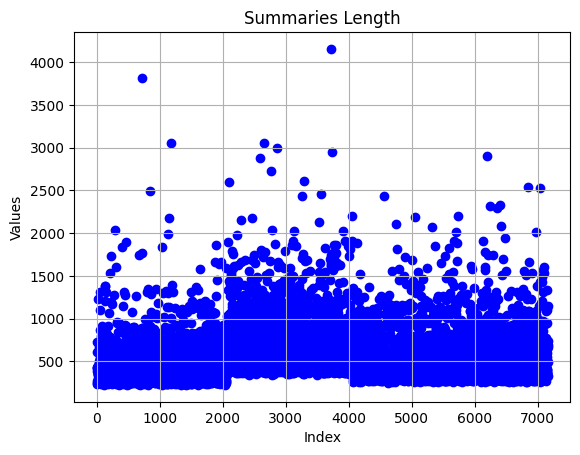

In [17]:
# Plot the lengths of the inputs
plt.scatter(train['input'].index, train['input'].apply(len).values, marker='o', color='blue')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Summaries Length')
plt.grid(True)
plt.show()

In [18]:
# Preprocessing features and labels

# Tokenize text data

# Change MAX_SUMMARY_LENGTH to 1500
MAX_SUMMARY_LENGTH = 1500 # int(train['input'].apply(len).mean())

# DEBERTA / RoBERTa Tokenizing
X_train = tokenizer.batch_encode_plus(train['input'].tolist(),
                                              add_special_tokens=True,
                                              truncation=True,
                                              padding='max_length',
                                              return_tensors='tf',
                                              max_length=MAX_SUMMARY_LENGTH,
                                              return_attention_mask = True)

Y_train = tf.constant(train[['content', 'wording']].values, dtype=tf.float32)

In [19]:
# def get_embeddings(input_ids, attention_mask, model_name):
    
#     # Forward pass through pre trained model
#     outputs = pre_trained_model(input_ids=input_ids, attention_mask=attention_mask)
    
#     if model_name == 'roberta-large':
#         return outputs['pooler_output']
#     else:
#         return outputs[0]

In [20]:
# Save roberta/deberta embeddings in the training set
# WORKS ONLY WITH 7615 ENTRIES! if this number changes 
# then change the insertion to averaged_embeddings outside of the loop

# batch_size = 8
# num_batches = len(X_train['input_ids']) // batch_size
# averaged_embeddings = []

# for i in range(num_batches):
#     inputs = X_train['input_ids'][i * batch_size : (i+1) * batch_size]
#     masks = X_train['attention_mask'][i * batch_size : (i+1) * batch_size]
    
#     embeddings = get_embeddings(input_ids=inputs, attention_mask=masks, model_name)
    
#     # pooled = embeddings.numpy()
#     pooled = (tf.reduce_mean(embeddings, axis=1)).numpy()
    
#     averaged_embeddings.append(pooled)
    
#     if i % int(num_batches * 0.1) == 0:
#         print(f"Batch {i}/{num_batches}")
        
#     del embeddings
#     tf.keras.backend.clear_session()

    
# # CHANGE HERE IF NEEDED: Add roberta/deberta outputs that are not being added in the loop
# inputs = X_train['input_ids'][-5:]
# masks = X_train['attention_mask'][-5:]  
# embeddings = get_embeddings(input_ids=inputs, attention_mask=masks, model_name)

# # pooled = embeddings.numpy()
# pooled = (tf.reduce_mean(embeddings, axis=1)).numpy()

# averaged_embeddings.append(pooled)

# del embeddings
# tf.keras.backend.clear_session()
    
# concatenated_embeddings = np.concatenate(averaged_embeddings, axis=0)
# train['embeddings'] = list(concatenated_embeddings)

In [21]:
# df_with_embeddings = train[['input', 'embeddings']]
# df_with_embeddings['embeddings']
# df_with_embeddings

In [9]:
# Save file to output folder

# NOTE: if not running on Kaggle then modify the paths

# RoBERTa
# file_path = '/kaggle/working/cls_embeddings.csv' # from working folder
file_path = '/kaggle/input/cls-roberta-embeddings/cls_embeddings.csv' # from input folder
# DeBERTa 
# file_path = '/kaggle/working/pooled_deberta_embeddings.csv'# from working folder
# file_path = '/kaggle/input/pooled-deberta-embeddings/pooled_deberta_embeddings.csv'# from input folder

# df_to_save = df_with_embeddings['pooled_roberta_embedding'].apply(lambda x: ','.join(map(str, x)))
# df_to_save.to_csv(file_path, index=False)

In [10]:
X_train_preprocessed = pd.read_csv(file_path)

# # Convert the embeddings column from strings to lists
X_train_preprocessed['embeddings'] = X_train_preprocessed['embeddings'].apply(lambda x: list(map(float, x.split(','))))
X_train_preprocessed['embeddings']

0       [-0.71352684, 0.6925065, 0.3142172, -0.8254234...
1       [-0.6972696, 0.71486264, 0.31027025, -0.847312...
2       [-0.63828003, 0.7129608, 0.09385701, -0.841408...
3       [-0.69163805, 0.68722314, 0.3459062, -0.821365...
4       [-0.663324, 0.6752366, 0.26772952, -0.81998545...
                              ...                        
7160    [-0.7271798, 0.6452826, 0.2498256, -0.8443753,...
7161    [-0.7327928, 0.66692114, 0.3054757, -0.8545221...
7162    [-0.68437356, 0.6610412, 0.1418359, -0.8494214...
7163    [-0.70200753, 0.6500007, 0.26053315, -0.838594...
7164    [-0.68358135, 0.64631164, 0.26508346, -0.87539...
Name: embeddings, Length: 7165, dtype: object

In [24]:
# !rm -rf ./logs/fit

In [25]:
# NN with embeddings preprocessed

input_shape = len(X_train_preprocessed['embeddings'][0])


input_layer = keras.Input(shape=(input_shape, ), dtype='float32')

hidden_layer = layers.Dense(256, activation='linear')(input_layer)

batch_norm = layers.BatchNormalization()(hidden_layer)

output_layer = layers.Dense(2, activation='linear')(batch_norm)
    
# Define the model
model = keras.Model(inputs=input_layer, outputs=output_layer)

for layer in model.layers:
    layer.trainable = True
    
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,938 (1.01 MB)

 Trainable params: 263,426 (1.00 MB)

 Non-trainable params: 512 (2.00 KB)

In [26]:
# Compile the model (add loss, optimizer, metrics)

# The loss function
def mcrmse(y_true, y_pred):
    columnwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
    return tf.reduce_mean(tf.sqrt(columnwise_mse), axis=-1)

initial_learning_rate = 0.0001

model.compile(
    loss=mcrmse,
    optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
    metrics=['r2_score']
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [27]:
# TRAIN PRE-PROCESSED VERSION
# Train the model

# model.load_weights('/kaggle/input/model-weights/saved_model_weights.weights.h5')

X_train_input = np.array(X_train_preprocessed['embeddings'].tolist())
Y_train = tf.constant(train[['content', 'wording']].values, dtype=tf.float32)

model.fit(x=X_train_input,
          y=Y_train,
          epochs=20,
          batch_size=16,
          validation_split=0.2,
          callbacks=[tensorboard_callback, early_stopping],
          verbose=2)

Epoch 1/20



I0000 00:00:1713296637.066831      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

W0000 00:00:1713296637.081671      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update

W0000 00:00:1713296638.552301      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update

W0000 00:00:1713296639.897892      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 - 6s - 16ms/step - loss: 0.7380 - r2_score: 0.4749 - val_loss: 1.4657 - val_r2_score: -1.6618e+00

Epoch 2/20


W0000 00:00:1713296640.307424      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 - 1s - 4ms/step - loss: 0.6250 - r2_score: 0.6285 - val_loss: 1.1817 - val_r2_score: -7.0875e-01

Epoch 3/20

359/359 - 1s - 3ms/step - loss: 0.5981 - r2_score: 0.6592 - val_loss: 0.9339 - val_r2_score: -2.3880e-01

Epoch 4/20

359/359 - 1s - 3ms/step - loss: 0.5836 - r2_score: 0.6751 - val_loss: 0.9699 - val_r2_score: -2.0325e-01

Epoch 5/20

359/359 - 1s - 3ms/step - loss: 0.5737 - r2_score: 0.6856 - val_loss: 1.0061 - val_r2_score: -2.3964e-01

Epoch 6/20

359/359 - 1s - 3ms/step - loss: 0.5663 - r2_score: 0.6933 - val_loss: 1.0318 - val_r2_score: -2.8357e-01

Epoch 7/20

359/359 - 1s - 4ms/step - loss: 0.5605 - r2_score: 0.6993 - val_loss: 1.0460 - val_r2_score: -3.1458e-01

Epoch 8/20

359/359 - 1s - 3ms/step - loss: 0.5556 - r2_score: 0.7042 - val_loss: 1.0349 - val_r2_score: -2.8745e-01


In [28]:
# Create the 'model' directory if it does not exist
# if not os.path.exists('model'):
#     os.makedirs('model')

# print("X_train element:")
# print(X_train['input_ids'][:1])
# print(X_train['attention_mask'][:1])
# print()
# print("Y_train element:")
# print(Y_train[0])
# print()
# print(f"X_train shape: (2, {X_train['input_ids'].shape}, {X_train['attention_mask'].shape}) ")
# print(f"Y_train shape: {Y_train.shape}")

In [29]:
# Create a layer that wraps the RoBERTa model to support Keras library
# class RoBERTaWrapper(layers.Layer):
#     def __init__(self, roberta_model, **kwargs):
#         super().__init__(**kwargs)
#         self.roberta = roberta_model

#     def call(self, inputs):
#         roberta_input1 = inputs[0]
#         roberta_input2 = inputs[1]

#         # Call the roberta model and get the last hidden state
#         roberta_output = self.roberta(input_ids=roberta_input1,
#                                       attention_mask=roberta_input2)
#         return roberta_output['last_hidden_state']

In [30]:
# Define keras neural network with Functional API

# Explanation of the Functional API: 
# For every layer we specify between parentheses at the end of the line the previous layer which will be the input.

# input_layer1 = keras.Input(shape=(MAX_SUMMARY_LENGTH,), dtype='int32')
# input_layer2 = keras.Input(shape=(MAX_SUMMARY_LENGTH,), dtype='int32')

# roberta_output = RoBERTaWrapper(roberta)([input_layer1, input_layer2])
# global_avg_pooling = layers.GlobalAveragePooling1D()(roberta_output)

# hidden_layer = layers.Dense(256, activation='linear')(global_avg_pooling)
# batch_norm = layers.BatchNormalization()(hidden_layer)
# output_layer = layers.Dense(2, activation='linear')(batch_norm)

# # Define the model
# model = keras.Model(inputs=[input_layer1, input_layer2], outputs=output_layer)

# # Make roberta params untrainable
# for layer in model.layers[:-4]:
#     layer.trainable = False
    
# model.summary()

In [31]:
# Train the model

In [32]:
# Clear any logs from previous runs
# !rm -rf ./logs/
# num_of_samples = 10

# inputs = X_train['input_ids']
# masks = X_train['attention_mask']
# # Train the model

# model.load_weights('/kaggle/input/model-weights/saved_model_weights.weights.h5')
# model.fit(x=[inputs, masks],
#           y=Y_train,
#           epochs=5,
#           batch_size=16,
#           validation_split=0.2,
#           callbacks=[tensorboard_callback, early_stopping],
#           verbose=2)

# # Create the 'model' directory if it does not exist
# if not os.path.exists('model'):
#     os.makedirs('model')

In [33]:
# model.save_weights('model/saved_model_weights.weights.h5')

In [34]:
# !rm -rf ./logs/fit

In [35]:
# import shutil
# # Zip the logs directory for downloading it locally 
# shutil.make_archive("/kaggle/working/logs", "zip", "./logs")
# shutil.make_archive("/kaggle/working/model", "zip", "./model")

In [36]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [37]:
# Reload the TensorBoard notebook extension if needed
# %reload_ext tensorboard

In [38]:
# http://localhost:6006/
# %tensorboard --logdir logs/fit --port=6006

In [39]:
# Demo of the model

In [40]:
# model.load_weights('/kaggle/input/model-weights/saved_model_weights.weights.h5')

In [41]:
# def eval_summary(prompt, question, summary):
#     spell(summary)
#     sample = prompt + sep + question + sep + summary
#     tokenized_summary = tokenizer(sample,
#                                   add_special_tokens=True,
#                                   truncation=True,
#                                   padding='max_length',
#                                   return_tensors='tf',
#                                   max_length=MAX_SUMMARY_LENGTH,
#                                   return_attention_mask = True)

#     output = model([tokenized_summary['input_ids'], tokenized_summary['attention_mask']])
#     print(f"Content: { output[0][0]} \nWording: {output[0][1]}")
#     # return output[0][0], output[0][1]

In [42]:
# Input Demo 
# sample_index = 8
# prompt = train['prompt_title'][sample_index]
# question = train['prompt_question'][sample_index]
# summary = train['text'][sample_index]
# print(f"prompt: {prompt}\n")
# print(f"question: {question}\n")
# print(f"summary: {summary}")

In [43]:
# # Output of the model
# print('Predicted Scores:')
# eval_summary(prompt, question, summary)

# # Real Scores
# print(f"\nReal Scores:\nContent: {train['content'][sample_index]}\nWording: {train['wording'][sample_index]}")